## 03: Spatial Interpolation - Basic Techniques

**Goal:** To predict values at unsampled locations using data from a limited number of sample points. This is a foundational task for creating continuous surfaces, essential for environmental monitoring, resource management, and more.

In this notebook, we'll explore two common methods:
1.  **Inverse Distance Weighting (IDW):** A straightforward deterministic method where the influence of a sample point is inversely proportional to its distance from the prediction location.
2.  **Machine Learning Approach:** Using a standard regression model (`RandomForestRegressor`) where the spatial coordinates (X and Y) are the primary features to predict the value.

### 1. Setup and Library Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import Rbf
import contextily as cx

### 2. Generate Synthetic Data

To test our interpolation methods, we need data where we know the "ground truth." We'll create a synthetic landscape where a value (e.g., temperature) is determined by a mathematical function. Then, we'll take a small number of random samples from this landscape, simulating real-world sensor readings.

In [2]:
# Define the boundary for our study area
x_min, x_max = 0, 100
y_min, y_max = 0, 100

# Ground Truth Function: A combination of peaks
def ground_truth_func(x, y):
    return (100 * np.exp(-((x - 25)**2 + (y - 75)**2) / 200) + 
            75 * np.exp(-((x - 70)**2 + (y - 30)**2) / 300) + 
            50 * np.sin(x/10) + 50 * np.cos(y/10))

# Create a dense grid for visualizing the ground truth
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid_z_truth = ground_truth_func(grid_x, grid_y)

# Generate random sample points (our 'sensors')
num_samples = 50
np.random.seed(42)
sample_x = np.random.uniform(x_min, x_max, num_samples)
sample_y = np.random.uniform(y_min, y_max, num_samples)
sample_z = ground_truth_func(sample_x, sample_y) + np.random.normal(0, 5, num_samples) # Add some noise

# Create a GeoDataFrame for the sample points
samples_gdf = gpd.GeoDataFrame(
    {'value': sample_z},
    geometry=[Point(x, y) for x, y in zip(sample_x, sample_y)],
    crs="EPSG:32630" # Using a projected CRS like UTM Zone 30N for distance calcs
)

### 3. Visualize the Ground Truth and Sample Points

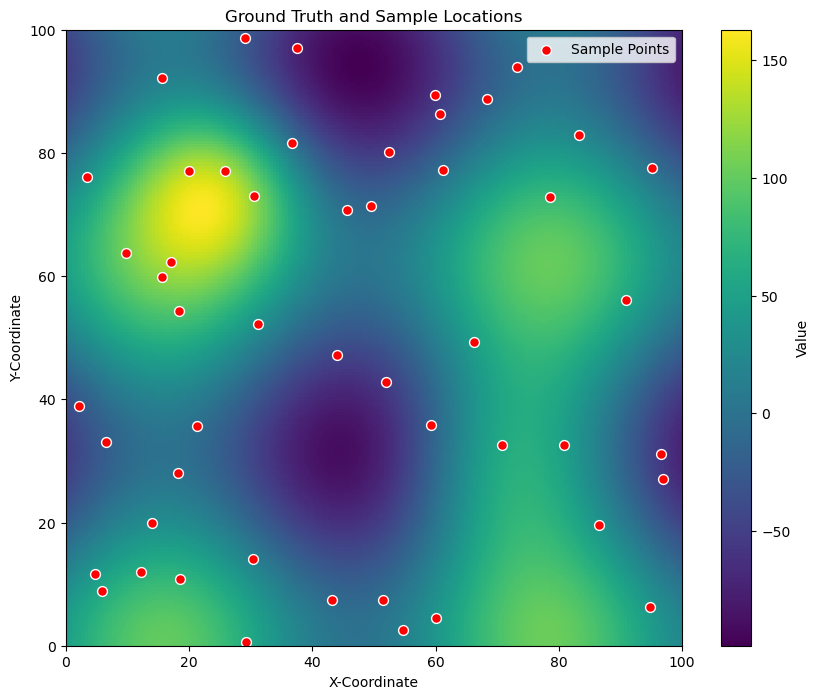

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
im = ax.imshow(grid_z_truth, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis')
samples_gdf.plot(ax=ax, marker='o', color='red', markersize=50, edgecolor='white', label='Sample Points')
ax.set_title('Ground Truth and Sample Locations')
ax.set_xlabel('X-Coordinate')
ax.set_ylabel('Y-Coordinate')
ax.legend()
fig.colorbar(im, ax=ax, label='Value')
plt.show()

### 4. Interpolation Method 1: Inverse Distance Weighting (IDW)

IDW assumes that points closer to the prediction location are more similar and should have more weight. The weight is typically `1/d^p`, where `d` is the distance and `p` is a power parameter (usually 2).

We will use `scipy.interpolate.Rbf` (Radial Basis Function) to perform a similar type of interpolation, which is flexible and effective.

In [5]:
# Create the RBF interpolator function
# The 'function' argument determines the type of radial basis function.
# 'inverse_multiquadric' is a common choice for smooth interpolation.
rbfi = Rbf(sample_x, sample_y, sample_z, function='inverse_multiquadric')

# Apply the interpolator to our dense grid
grid_z_idw = rbfi(grid_x, grid_y)

### 5. Interpolation Method 2: Machine Learning (Random Forest)

Here, we treat interpolation as a standard regression problem. The features (`X`) are the coordinates of our sample points, and the target (`y`) is the value at those points. We train a model and then ask it to predict the values for every point on our dense grid.

In [6]:
# Prepare the training data
X_train = np.vstack([sample_x, sample_y]).T
y_train = sample_z

# Prepare the prediction data (the entire grid)
X_predict = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on the grid
grid_z_rf = rf.predict(X_predict)
grid_z_rf = grid_z_rf.reshape(grid_x.shape) # Reshape back to grid format

### 6. Compare the Results

Now we can visually compare our two interpolated surfaces against the ground truth.

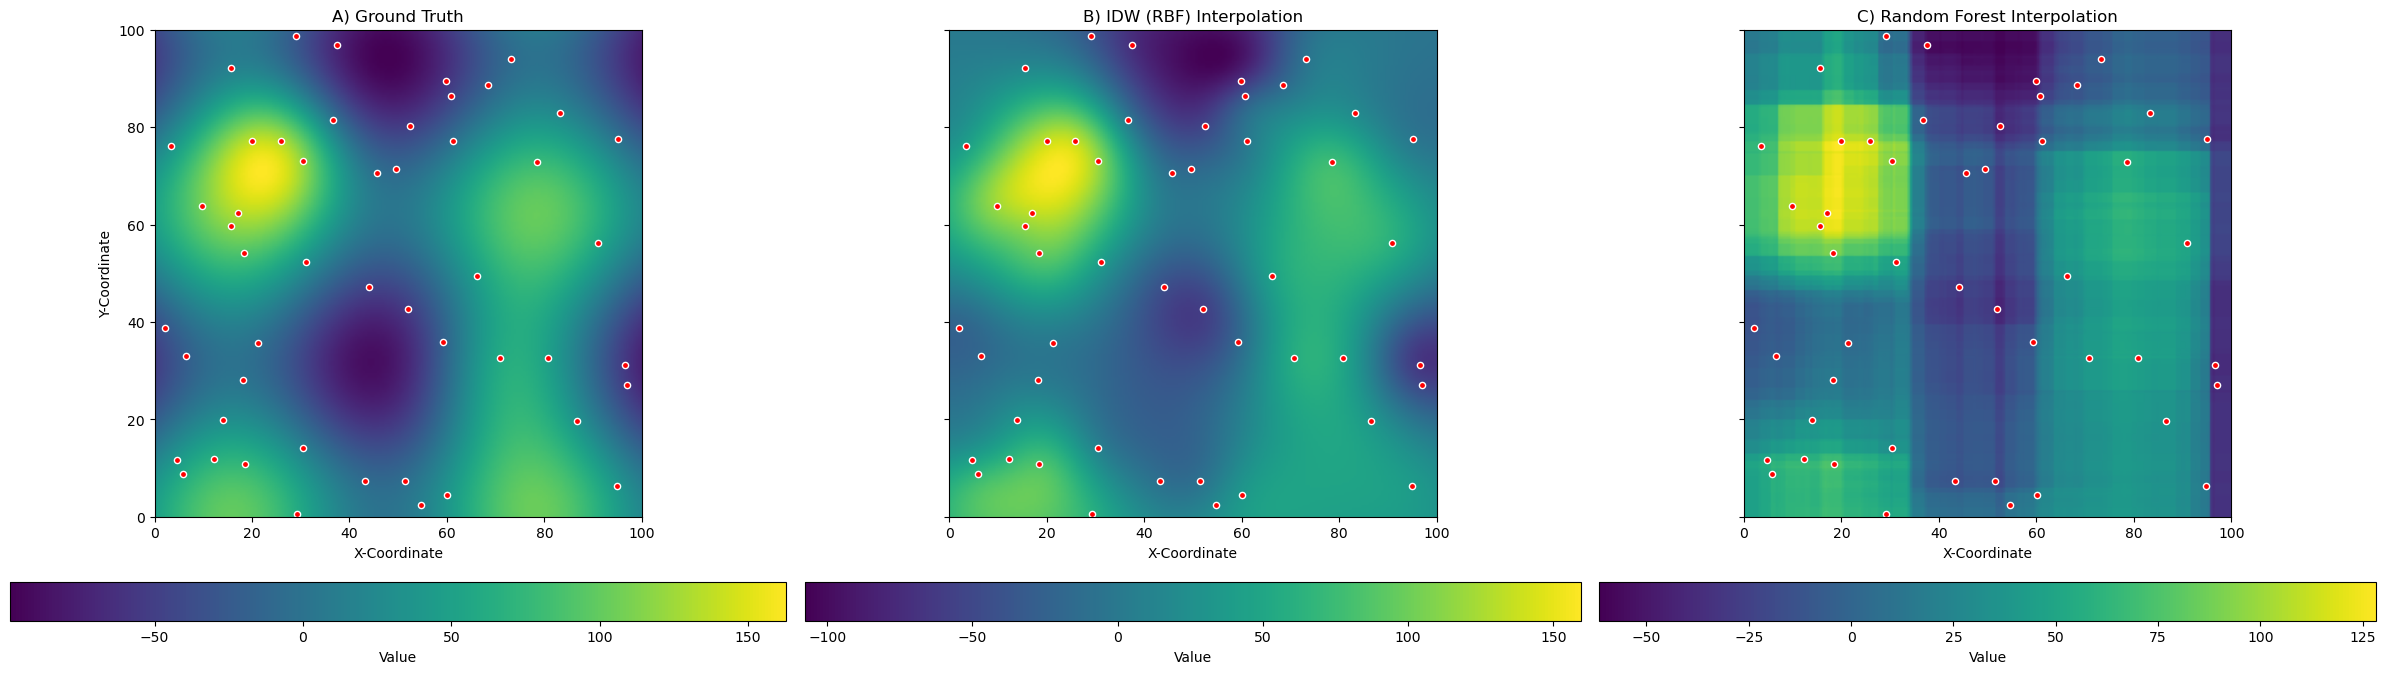

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)

# Plot Ground Truth
im0 = axes[0].imshow(grid_z_truth, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis')
axes[0].scatter(sample_x, sample_y, c='red', edgecolor='white', s=20)
axes[0].set_title('A) Ground Truth')
axes[0].set_xlabel('X-Coordinate')
axes[0].set_ylabel('Y-Coordinate')
fig.colorbar(im0, ax=axes[0], orientation='horizontal', pad=0.1, label='Value')

# Plot IDW (RBF) Interpolation
im1 = axes[1].imshow(grid_z_idw, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis')
axes[1].scatter(sample_x, sample_y, c='red', edgecolor='white', s=20)
axes[1].set_title('B) IDW (RBF) Interpolation')
axes[1].set_xlabel('X-Coordinate')
fig.colorbar(im1, ax=axes[1], orientation='horizontal', pad=0.1, label='Value')

# Plot Random Forest Interpolation
im2 = axes[2].imshow(grid_z_rf, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis')
axes[2].scatter(sample_x, sample_y, c='red', edgecolor='white', s=20)
axes[2].set_title('C) Random Forest Interpolation')
axes[2].set_xlabel('X-Coordinate')
fig.colorbar(im2, ax=axes[2], orientation='horizontal', pad=0.1, label='Value')

plt.tight_layout()
plt.show()

# Discussion:
# - The RBF/IDW method (B) creates a very smooth, visually pleasing surface that honors the sample points exactly. It's a classic interpolation result.
# - The Random Forest method (C) produces a more patchy result. This is characteristic of tree-based models. It doesn't extrapolate beyond the range of the training data well but can capture complex, non-linear relationships if enough data is provided.
# - Neither method perfectly recreates the ground truth, which is expected given the sparse and noisy sample data. The best method often depends on the nature of the data and the specific goals of the analysis.